# UFO

<font color='#660066'>
   
### Table of Contents

- [Data](#Data)
    - [Scraping from UFORC](#Scraping-from-UFORC)
    - [Data Format](#data_format)
    - [Cleaing Data](#cleaning_pdata)
- [Basic anlayis](#Basic-Anylsis)
- [Milestone 3](#milestones)

In [62]:
%load_ext autoreload
%autoreload 2
import json
import pandas as pd
from matplotlib.pyplot import *
from lib.scraping import fetch_shape_urls,  \
                     fetch_all_sighting_urls, \
                     store_to_json, \
                     build_report_dataframe
from lib.postprocessing import get_time_of_occurrence, \
                           to_datetime_add_year, \
                           replace_empty_with_nan, \
                           distribution_histogram 
from lib.cleaning import clean_data, \
                        clean_duration_get_min
from lib.nuforc_analysis import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data_folder = "data/"

file_url_list = data_folder+'full_list_of_urls.json'

report_file = 'jurgis_full.csv'

<font color='#660066'>
    
## Loading data

of course we dont want so scrape every time

In [3]:
df_reports = pd.read_csv(data_folder+report_file)
df_reports.sample(1).head()

,Unnamed: 0,Duration,Location,Occurred,Posted,Reported,Shape,Summary,url
32441,23519,5-7 minutes,"Deland, FL",3/15/2016 02:30 (Entered as : 03/15/2016 02:30),3/24/2016,3/22/2016 2:14:57 AM 02:14,Cross,"['I was on the backside of Blue Lake, looking ...",http://www.nuforc.org/webreports/126/S126492.html


In [4]:
df_reports, df_madarr = clean_data(df_reports)

In [5]:
df_reports.sample(1).head()

,Duration,Location,State,Occurred,Posted,Reported,Shape,Summary,nuforc_note,link
url,,,,,,,,,,
http://www.nuforc.org/webreports/057/S57253.html,15.0,Thomasville,GA,1971-04-15 21:00:00,8/7/2007,2007-06-23 11:34:00,Disk,"['I did not record the date, I could not tell ...",[((NUFORC Note: Witness indicates that the da...,[]


In [155]:
df_peaks = df_reports[['Occurred']].copy()
df_peaks = df_peaks[(df_peaks.Occurred.dt.year > 1900)]
index_list = df_peaks[df_peaks.Occurred.isna()].index
df_peaks = df_peaks.dropna()
df_peaks['year_month'] = df_peaks.Occurred.map(lambda x: x.strftime('%m'))
plotting_times = df_peaks.groupby(by='year_month').count()

Text(0,0.5,'Amount')

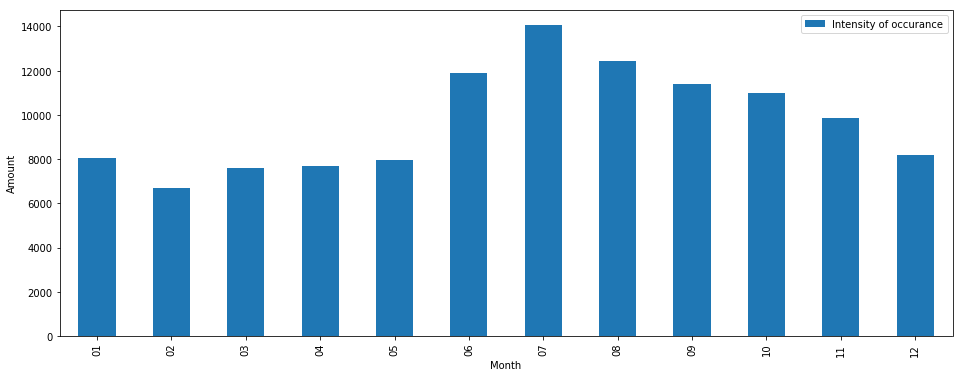

In [156]:
fig, ax = subplots()
plotting_times.plot.bar(figsize=(16,6), ax=ax)
ax.legend(['Intensity of occurance'])
xlabel("Month")
ylabel('Amount')

### Analysis
This plot shows the amount of reported occurances per month from 1900-2018.
We can see a very clear trend that during the summer months when there is an increase in submitted reports.
This can be reasoned with very logicaly, because during warmer periods people tend to spend more time outside, thus have a higher probability of making a sighting of a UFO.

But we see a clear increase in July, thus we will be investigating this month more, by plotting the reports from July over the time frame 1900 to 2018.

In [157]:
df_july = df_reports[['Occurred']].copy()
df_july = df_july[(df_july.Occurred.dt.year > 1900)]
df_july = df_july[(df_july.Occurred.dt.month == 7)]
index_list = df_july[df_july.Occurred.isna()].index
df_july = df_july.dropna()
df_july['days'] = df_july.Occurred.map(lambda x: x.strftime('%d'))
july_plotting_times = df_july.groupby(by='days').count()

Text(0,0.5,'Amount')

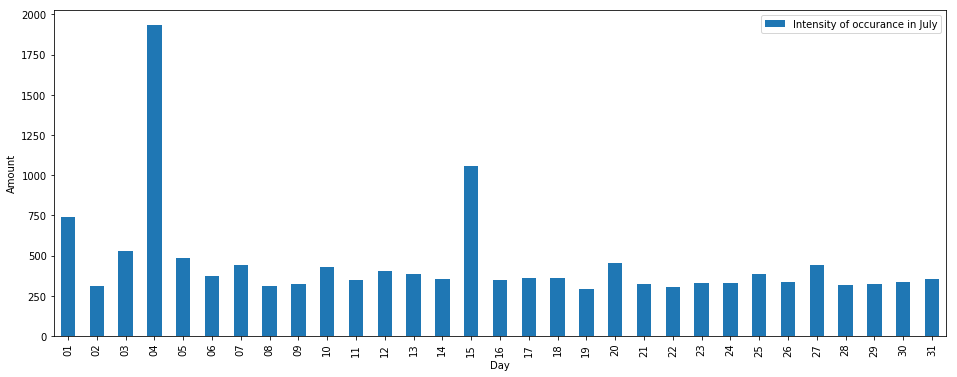

In [158]:
fig, ax = subplots()
july_plotting_times.plot.bar(figsize=(16,6), ax=ax)
ax.legend(['Intensity of occurance in July'])
xlabel("Day")
ylabel('Amount')

## Analysis
Now, here things start to become very interesting. We can quite obviously see an increase for the 4th of July, as a lot of sightings might be connected with the fireworks in the US. 

Though, another very clear increase is on the 15th of July, but after a google query, no specific occurance in the month of July was found. Thus, an investigation of the 15th of July over the years occurs. What is more interesting, is that the increase on the 15th day of the month can be seen across multiple months.

In [159]:
def get_data_for_months(df):
    df_month = df[['Occurred']].copy()
    df_month = df_month[(df_month.Occurred.dt.year > 1900)]
    months = []
    for i in range(1,13):
        df_month_iter = df_month[(df_month.Occurred.dt.month == i)].copy()
        index_list = df_month_iter[df_month_iter.Occurred.isna()].index
        df_month_iter = df_month_iter.dropna()
        df_month_iter['days'] = df_month_iter.Occurred.map(lambda x: x.strftime('%d'))
        each_month = df_month_iter.groupby(by='days').count()
        months.append(each_month)
    return months

In [160]:
months = get_data_for_months(df_reports)

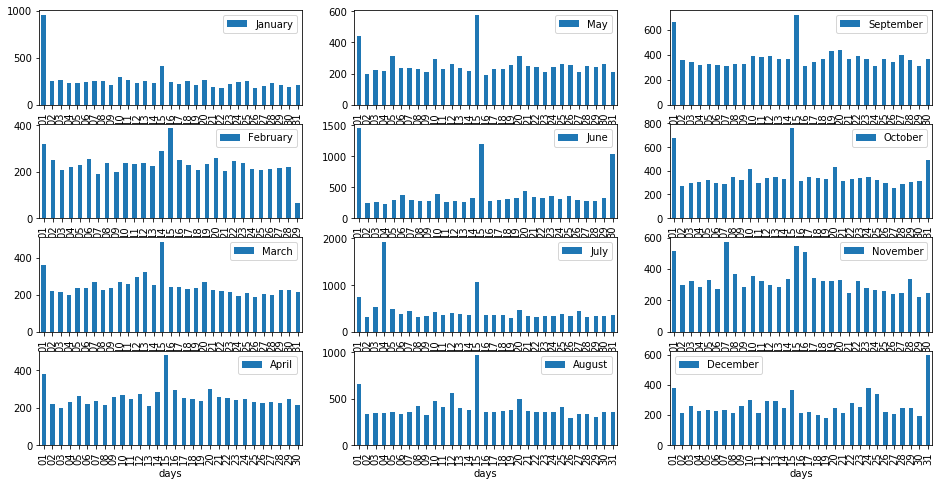

In [161]:
figs, axis = subplots(nrows=4,ncols=3)
months[0].plot.bar(ax=axis[0,0],figsize=(16,8))
axis[0,0].legend(['January'])
months[1].plot.bar(ax=axis[1,0])
axis[1,0].legend(['February'])
months[2].plot.bar(ax=axis[2,0])
axis[2,0].legend(['March'])
months[3].plot.bar(ax=axis[3,0])
axis[3,0].legend(['April'])
months[4].plot.bar(ax=axis[0,1])
axis[0,1].legend(['May'])
months[5].plot.bar(ax=axis[1,1])
axis[1,1].legend(['June'])
months[6].plot.bar(ax=axis[2,1])
axis[2,1].legend(['July'])
months[7].plot.bar(ax=axis[3,1])
axis[3,1].legend(['August'])
months[8].plot.bar(ax=axis[0,2])
axis[0,2].legend(['September'])
months[9].plot.bar(ax=axis[1,2])
axis[1,2].legend(['October'])
months[10].plot.bar(ax=axis[2,2])
axis[2,2].legend(['November'])
months[11].plot.bar(ax=axis[3,2])
axis[3,2].legend(['December'])

We can see a very clear trend across all months, that during the 15th day of the month there is a sudden increase in occured reportings of UFOs. Also, in most months there is a peak on the first day of the month. And in some months there are also other peaks, which most of the time can be explained due to holidays and such events.

Now to look into the 15th of July specifically over the years.

In [162]:
df_15july = df_reports[['Occurred']].copy()
df_15july = df_15july[(df_15july.Occurred.dt.year > 1900)]
df_15july = df_15july[(df_15july.Occurred.dt.month == 7)]
df_15july = df_15july[(df_15july.Occurred.dt.day== 15)]
index_list = df_15july[df_15july.Occurred.isna()].index
df_15july = df_15july.dropna()
df_15july['years'] = df_15july.Occurred.map(lambda x: x.strftime('%Y'))
july15_plotting_times = df_15july.groupby(by='years').count()

Text(0,0.5,'Amount')

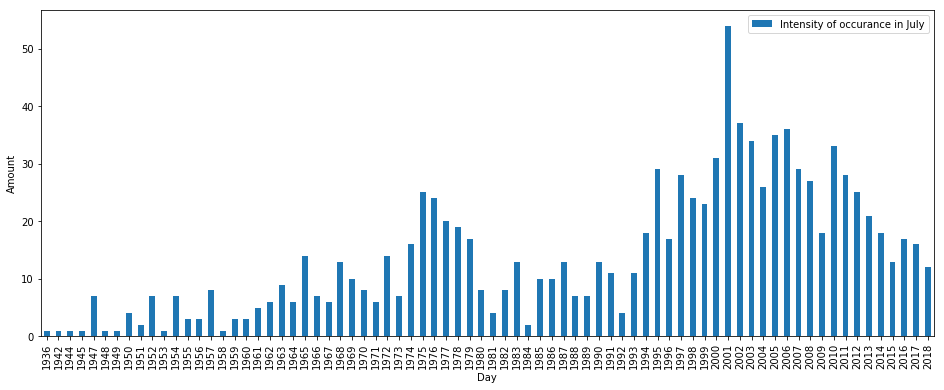

In [163]:
fig, ax = subplots()
july15_plotting_times.plot.bar(figsize=(16,6), ax=ax)
ax.legend(['Intensity of occurance in July'])
xlabel("Day")
ylabel('Amount')

We see no particaular increase on the 15th of July over the years, so there might be some other reason for this phenomena.

Thus, we're going to do some more indepth analysis on these reports - text analysis, time of report, duration.

In [165]:
df_15th = df_reports[['Occurred']].copy()
df_15th = df_15th[(df_15th.Occurred.dt.year > 1900)]
df_15th = df_15th[(df_15th.Occurred.dt.day == 15)]
index_list = df_15july[df_15th.Occurred.isna()].index
df_15th = df_15th.dropna()
df_15th['15th over years'] = df_15th.Occurred.map(lambda x: x.strftime('%Y'))
plotting_15th_day = df_15th.groupby(by='15th over years').count()

C:\Users\jurgi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


Text(0,0.5,'Amount')

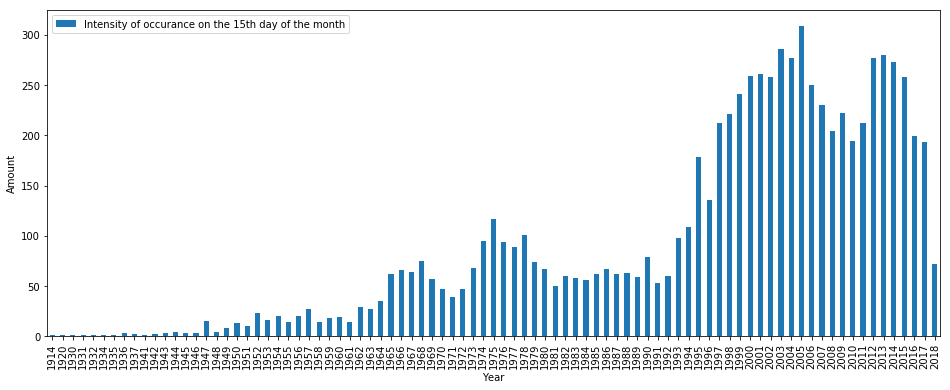

In [166]:
fig, ax = subplots()
plotting_15th_day.plot.bar(figsize=(16,6), ax=ax)
ax.legend(['Intensity of occurance on the 15th day of the month'])
xlabel("Year")
ylabel('Amount')

And again, nothing specific can be noticed for the 15th day of the month.

Thus, exctracting the reports of the 15th day of the month.

In [171]:
df_15th_full = df_reports.copy()
df_15th_full = df_15th_full[(df_15th_full.Occurred.dt.year > 1900)]
df_15th_full = df_15th_full[(df_15th_full.Occurred.dt.day == 15)]
df_15th_full.head()

,Duration,Location,State,Occurred,Posted,Reported,Shape,Summary,nuforc_note,link
url,,,,,,,,,,
http://www.nuforc.org/webreports/116/S116228.html,5.000000,Lenoir City,TN,2014-12-15 05:30:00,1/7/2015,2014-12-28 18:11:00,Triangle,['My wife and I were on our way to work. She s...,[],[]
http://www.nuforc.org/webreports/115/S115561.html,4.500000,Newark,TX,2014-11-15 20:35:00,11/26/2014,2014-11-23 06:46:00,Triangle,['3 Black Triangular Objects flying silently o...,[((NUFORC Note: Witness has been known to our...,[]
http://www.nuforc.org/webreports/115/S115416.html,0.083333,Attleboro,MA,2014-11-15 18:20:00,11/21/2014,2014-11-17 07:12:00,Triangle,"['Triangle black, no light in any side. 3 or ...",[],[]
http://www.nuforc.org/webreports/114/S114566.html,5.000000,Flagstaff,AZ,2014-10-15 19:30:00,11/6/2014,2014-10-15 20:10:00,Triangle,['Three yellow lighted hovered next to my car ...,[],[]
http://www.nuforc.org/webreports/114/S114570.html,3.000000,Lorain,OH,2014-10-15 19:28:00,11/6/2014,2014-10-15 22:59:00,Triangle,['Five flashing triangular objects viewed from...,[],[]


## Scrapping Air-base, rocket launch locations

### Nevermind, Kiru will do it with VIM, too good for me

# Getting some weather shit in this place

In [140]:
!ls data/weather/

StormEvents_details-ftp_v1.0_d1950_c20170120.csv.gz
StormEvents_locations-ftp_v1.0_d1996_c20170717.csv.gz


In [129]:
storm_folder = 'data/weather/'

In [143]:
storms = pd.read_csv(storm_folder+'StormEvents_details-ftp_v1.0_d1950_c20170120.csv.gz')
#storms = pd.read_csv(storm_folder+'StormEvents_locations-ftp_v1.0_d1996_c20170717.csv.gz')

In [145]:
storms.shape

(223, 51)